In [106]:
%reload_ext autoreload
%autoreload 2
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.stats import multivariate_normal
from jax.config import config
config.update(
    "jax_enable_x64", True
)
from functools import partial


import matplotlib.pyplot as plt

## define our sampler

In [295]:
# for visual purposes, no metropolis correction! see the metropolis notebook.
class hmc():
    def __init__(self, dim, logpi_q, mass, PRNGkey, dt=0.1, L=10):
        # Basic attr.
        self.dim = dim
        self.dt = dt
        self.L = L
        self.PRNGkey = PRNGkey
        
        # Read the position space posterior
        # (Potential energy)
        self.logpi_q = logpi_q
        self.negdV = grad(self.logpi_q)
        
        # Construct the momentum sampler
        self.mass = mass
        self.massinv = jnp.linalg.inv(mass)
        
    def logpi_p_q(self, p, q):
        # the log pi(p|q) (Kinetic energy)
        # -dim/2*log(2 pi) - (p^T M^-1 p) / 2
        return multivariate_normal.logpdf(p, 
                                            mean=jnp.zeros(self.dim), 
                                            cov=self.massinv)
    
    # Construct the Hamiltonian
    def H(self, p, q):
        return -self.logpi_p_q(p,q)-self.logpi_q(q)
    
    # ----------------
    # Define the leap frog intergator
    @partial(jit, static_argnums=(0,)) # partial jit for class type argument at 0
    def _leapfrog_incre(self, q0, p0):
        # update momentum by half time step
        p_halfdt = p0 + self.dt/2*self.negdV(q0)
        # update position by full time step
        q_dt = q0 + self.dt * self.massinv@p_halfdt
        # update momentum by full time step
        p_dt = p_halfdt + self.dt/2*self.negdV(q_dt)
        return q_dt,p_dt
    
    def _leapfrog(self, q0, p0):
        # integrate L times
        for _ in range(self.L):
            q0,p0 = self._leapfrog_incre(q0,p0)
        return q0,p0
    
    # Generate 1 sample
    def next_sample(self, q0):
        self.PRNGkey, subkey = random.split(self.PRNGkey)
        p0 = random.multivariate_normal(key=subkey, mean=jnp.zeros(self.dim), cov=self.mass, method='cholesky')
        qf, pf = self._leapfrog(q0,p0)
        return qf

    # Generate N samples
    def next_Nsample(self, q0, N):
        qs = -999*jnp.ones((N,self.dim))
        for i in range(N):
            qs=qs.at[i].set(q0)
            q0 = self.next_sample(q0)
        return qs
    
    # ----------------
    # The verbose integrator
    def _leapfrog_verbose(self, q0, p0):
        # integrate L times
        qs = -999*jnp.ones((self.L,self.dim))
        ps = -999*jnp.ones((self.L,self.dim))
        for i in range(self.L):
            qs=qs.at[i].set(q0)
            ps=ps.at[i].set(p0)
            q0,p0 = self._leapfrog_incre(q0,p0)
        # return not only the final state but also the history
        return q0,p0,qs,ps
    
    # Generate 1 sample
    def next_sample_verbose(self, q0):
        self.PRNGkey, subkey = random.split(self.PRNGkey)
        p0 = random.multivariate_normal(key=subkey, mean=jnp.zeros(self.dim), cov=self.mass, method='cholesky')
        qf, pf, qs, ps = self._leapfrog_verbose(q0,p0)
        return qf, pf, qs, ps

## define our posterior function

In [296]:
def logpi_q(q):
    # the log posterior
    return multivariate_normal.logpdf(q, jnp.array([0,0]), jnp.array([[0.8,0],[0,1]]))

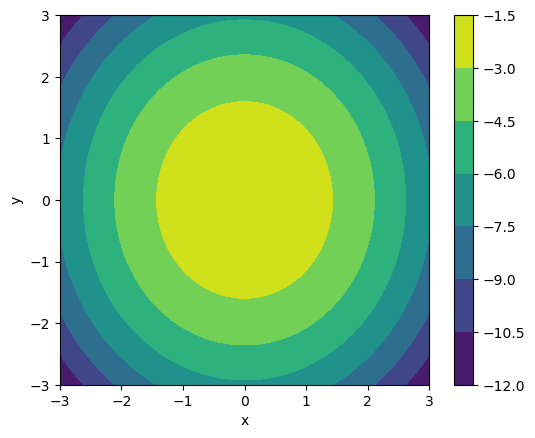

In [297]:
x = jnp.linspace(-3,3,100)
y = jnp.linspace(-3,3,100)
x_grid, y_grid = jnp.meshgrid(x, y)
z = logpi_q(
    jnp.swapaxes(
        jnp.swapaxes(jnp.array([x_grid,y_grid]),0,-1),
        0,1)
    )
h = plt.contourf(x_grid, y_grid, z)
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

## leap frog integration

In [298]:
# plotting helper func.
def quiver_2dline(q,color='k'):
    # q = [[x1, y1],[x2, y2],...]
    x,y = q.T
    plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color=color)

first sample: [ 0.35993016 -0.96797992]


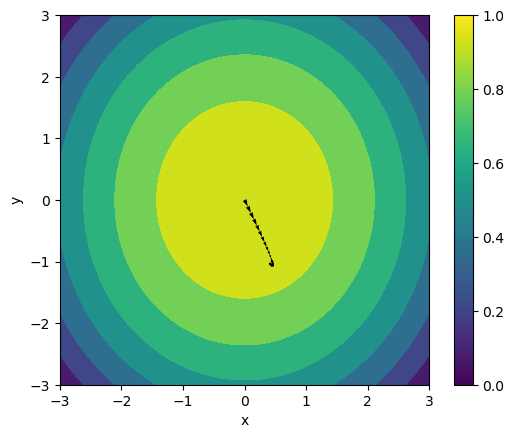

In [299]:
sampler = hmc(dim=2,
              logpi_q=logpi_q,
              mass=jnp.eye(2),
              PRNGkey=random.PRNGKey(1),
              L = 20)
# generate 1 point starting from q0 = [0,0]
qf, pf, qs, ps = sampler.next_sample_verbose(q0=jnp.zeros(2))
print('first sample:', qf)
# plot trajectory
h = plt.contourf(x_grid, y_grid, z)
quiver_2dline(qs)
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

## tracing the trajectories (no Metropolis correction)
- notice the momentum resampling at each step

q_0: [0.19557961 0.28836131]
q_1: [0.1867613  0.44952582]
q_2: [-0.12626967  0.26169095]
q_3: [-0.35798337  0.21840886]
q_4: [-0.68991114 -0.05348824]


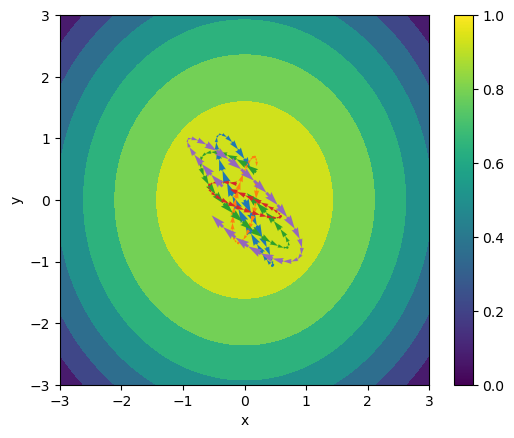

In [300]:
sampler = hmc(dim=2,
              logpi_q=logpi_q,
              mass=jnp.eye(2),
              PRNGkey=random.PRNGKey(1),
              dt = 0.2,
              L = 30)

h = plt.contourf(x_grid, y_grid, z)

qf = jnp.zeros(2)
for i in range(5):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    print(f'q_{i}:', qf)
    quiver_2dline(qs,color=f'C{i}')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

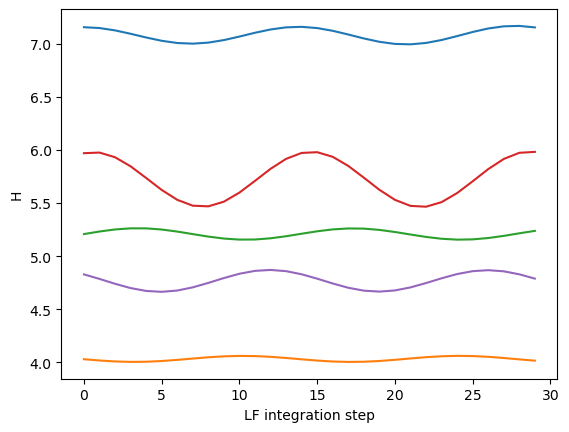

In [301]:
# the wiggles show the non-conservation of energy!! more later.
qf = jnp.zeros(2)
for i in range(5):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    h = sampler.H(qs,ps)
    plt.plot(h,color=f'C{i}')
plt.xlabel('LF integration step')
plt.ylabel('H')
plt.show()


#### mass matrix

q_0: [ 0.28422752 -0.60059878]
q_1: [ 0.23678119 -0.85363056]
q_2: [-0.24369858 -0.34801344]
q_3: [-0.54503548 -0.21728377]
q_4: [-0.9586516   0.37011249]


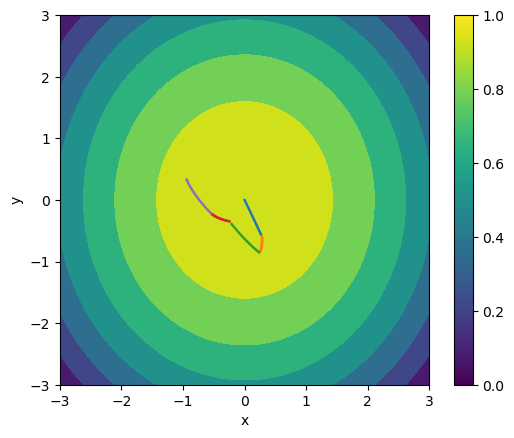

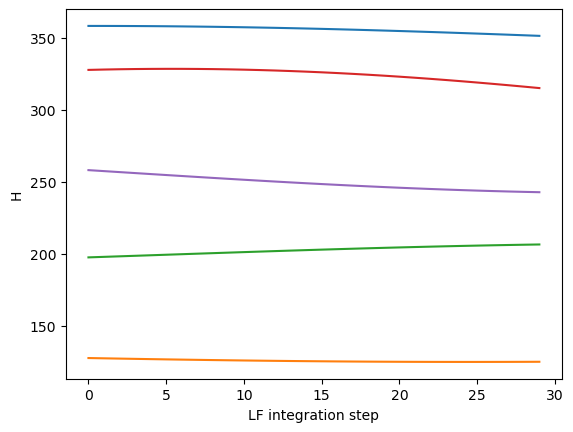

In [302]:
mass = jnp.eye(2)*100
sampler = hmc(dim=2,
              logpi_q=logpi_q,
              mass=mass,
              PRNGkey=random.PRNGKey(1),
              dt = 0.2,
              L = 30)

h = plt.contourf(x_grid, y_grid, z)

qf = jnp.zeros(2)
for i in range(5):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    print(f'q_{i}:', qf)
    quiver_2dline(qs,color=f'C{i}')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

qf = jnp.zeros(2)
for i in range(5):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    h = sampler.H(qs,ps)
    plt.plot(h,color=f'C{i}')
plt.xlabel('LF integration step')
plt.ylabel('H')
plt.show()

#### integration length

q_0: [-0.36702142  0.3350686 ]
q_1: [-0.23958108 -0.11849213]
q_2: [ 0.40971622 -0.08637493]
q_3: [0.70436735 0.04300195]
q_4: [ 1.11134899 -0.34736427]


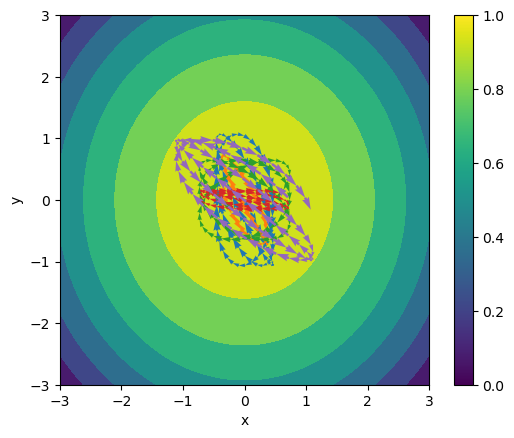

In [303]:
mass = jnp.eye(2)
sampler = hmc(dim=2,
              logpi_q=logpi_q,
              mass=mass,
              PRNGkey=random.PRNGKey(1),
              dt = 0.2,
              L = 80)

h = plt.contourf(x_grid, y_grid, z)

qf = jnp.zeros(2)
for i in range(5):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    print(f'q_{i}:', qf)
    quiver_2dline(qs,color=f'C{i}')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

#### integration error and metropolis correction
- two cases, same dt*L = constant

q_0: [0.00659601 0.        ]
q_1: [0.02095446 0.        ]
q_2: [-0.74141328  0.        ]
q_3: [-0.2493024  0.       ]
q_4: [-0.78706096  0.        ]


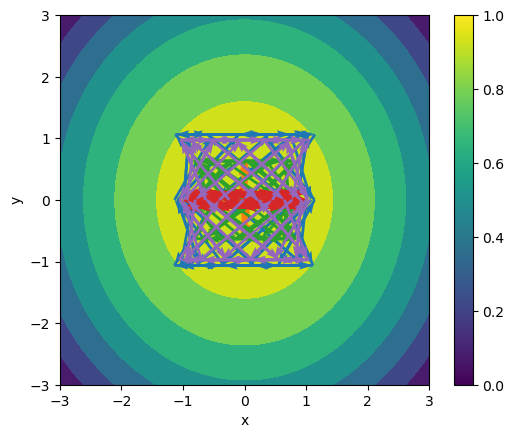

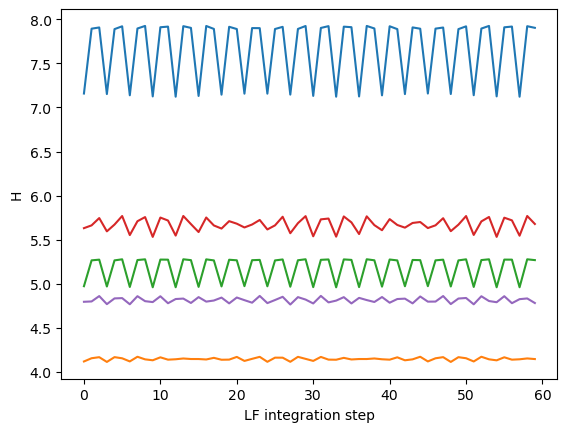

In [304]:
# large integration steps
mass = jnp.eye(2)
sampler = hmc(dim=2,
              logpi_q=logpi_q,
              mass=mass,
              PRNGkey=random.PRNGKey(1),
              dt = 1,
              L = 60)

h = plt.contourf(x_grid, y_grid, z)

qf = jnp.zeros(2)
qf = jnp.array([1.0,0.0])
for i in range(5):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    print(f'q_{i}:', qf)
    quiver_2dline(qs,color=f'C{i}')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

qf = jnp.zeros(2)
for i in range(5):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    h = sampler.H(qs,ps)
    plt.plot(h,color=f'C{i}')
plt.xlabel('LF integration step')
plt.ylabel('H')
plt.show()

q_0: [-0.83109192  0.34988685]
q_1: [ 0.32361252 -0.12194167]
q_2: [ 0.49519427 -0.0925194 ]
q_3: [0.31409537 0.0466376 ]
q_4: [ 0.64950866 -0.36413413]


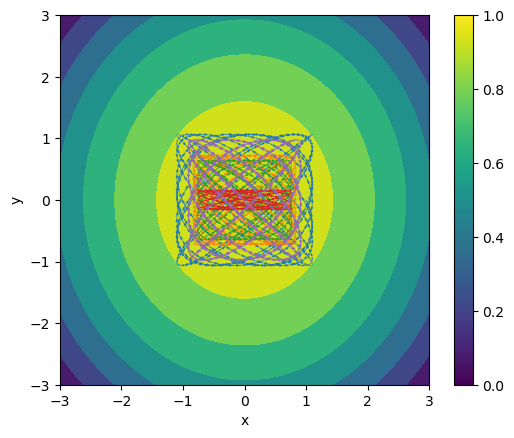

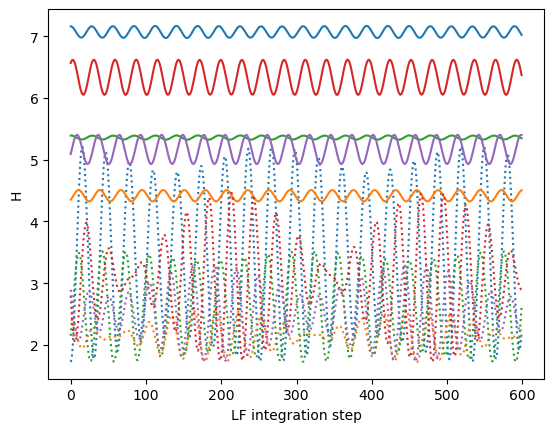

In [307]:
# small integration steps
mass = jnp.eye(2)
sampler = hmc(dim=2,
              logpi_q=logpi_q,
              mass=mass,
              PRNGkey=random.PRNGKey(1),
              dt = 0.1,
              L = 600)

h = plt.contourf(x_grid, y_grid, z)

qf = jnp.zeros(2)
qf = jnp.array([1.0,0.0])
for i in range(5):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    print(f'q_{i}:', qf)
    quiver_2dline(qs,color=f'C{i}')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

qf = jnp.zeros(2)
for i in range(5):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    h = sampler.H(qs,ps)
    v = -sampler.logpi_q(qs)
    plt.plot(v,color=f'C{i}',ls=":")
    plt.plot(h,color=f'C{i}')
plt.xlabel('LF integration step')
plt.ylabel('H')
plt.show()

## mixed Gaussian

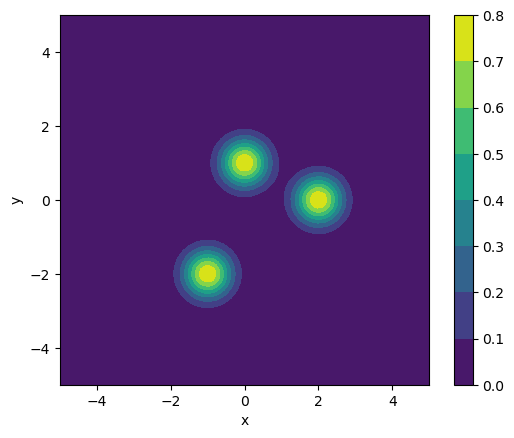

In [245]:
def logpi_q(q):
    # the log posterior
    res = multivariate_normal.pdf(q, jnp.array([0,1]), jnp.array([[0.2,0],[0,0.2]]))
    res += multivariate_normal.pdf(q, jnp.array([2,0]), jnp.array([[0.2,0],[0,0.2]]))
    res += multivariate_normal.pdf(q, jnp.array([-1,-2]), jnp.array([[0.2,0],[0,0.2]]))
    return jnp.log(res)

x = jnp.linspace(-5,5,100)
y = jnp.linspace(-5,5,100)
x_grid, y_grid = jnp.meshgrid(x, y)
z = jnp.exp(logpi_q(
    jnp.swapaxes(
        jnp.swapaxes(jnp.array([x_grid,y_grid]),0,-1),
        0,1)
    ))
h = plt.contourf(x_grid, y_grid, z)
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

q_0: [ 0.1068978  -0.11140205]
q_1: [ 0.10219603 -0.1207573 ]
q_2: [-0.0498782   0.12915512]
q_3: [-0.17858945  0.25424148]
q_4: [-0.35496209  0.54294173]
q_5: [-0.3745204   1.05341006]
q_6: [-0.40562239  0.95142847]
q_7: [-0.2439247   1.28945819]
q_8: [0.10347675 1.47473888]
q_9: [0.27186332 1.48761017]
q_10: [0.19580872 0.98226599]
q_11: [0.06633485 0.74890948]
q_12: [0.30067559 0.79827425]
q_13: [0.14921087 0.64650287]
q_14: [-0.23503373  0.46066963]


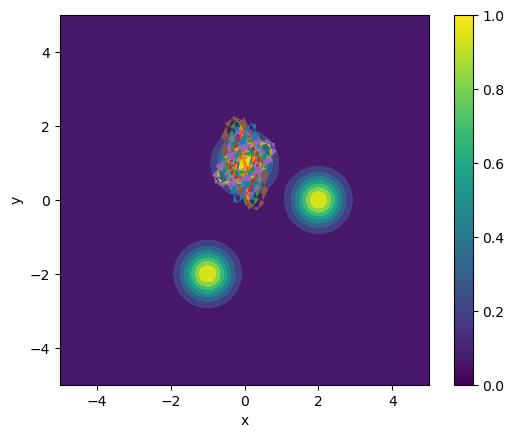

In [255]:
sampler = hmc(dim=2,
              logpi_q=logpi_q,
              mass=jnp.eye(2),
              PRNGkey=random.PRNGKey(1),
              dt = 0.2,
              L = 15)

h = plt.contourf(x_grid, y_grid, z)

qf = jnp.zeros(2)
for i in range(15):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    print(f'q_{i}:', qf)
    quiver_2dline(qs,color=f'C{i}')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

q_0: [0.19663856 0.02664357]
q_1: [0.13444606 0.19982595]
q_2: [-0.1939711   0.77182218]
q_3: [-0.35049636  0.91657707]
q_4: [-0.55652748  1.31744196]
q_5: [-0.4822546   2.02431933]
q_6: [-0.60512307  1.51362513]
q_7: [-0.19511397  1.9092779 ]
q_8: [0.42204064 1.92174001]
q_9: [0.56015016 1.64437892]
q_10: [0.24435942 0.58296234]
q_11: [-0.04922333  0.34457277]
q_12: [0.40225475 0.66238483]
q_13: [0.02570626 0.49585908]
q_14: [-0.63770058  0.31280052]
q_15: [0.10945291 0.60651988]
q_16: [0.37761859 0.1329475 ]
q_17: [ 2.36411561 -0.57759802]
q_18: [ 1.83591898 -0.37425353]
q_19: [1.86685686 0.06264111]


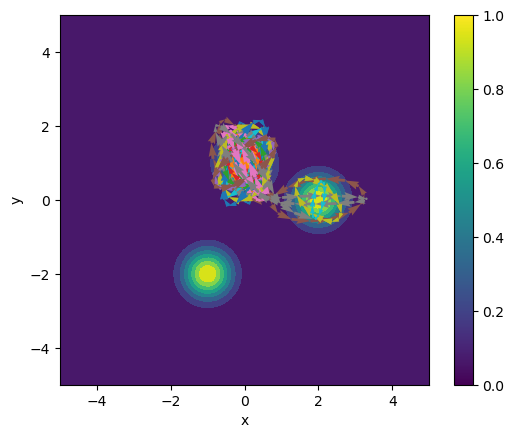

In [256]:
mass = jnp.array([[1,0],[0,1]])
sampler = hmc(dim=2,
              logpi_q=logpi_q,
              mass=mass,
              PRNGkey=random.PRNGKey(1),
              dt = 0.2,
              L = 30)

h = plt.contourf(x_grid, y_grid, z)

qf = jnp.zeros(2)
for i in range(20):
    # generate 1 point starting from q0 = [0,0]
    qf, pf, qs, ps = sampler.next_sample_verbose(q0=qf)
    print(f'q_{i}:', qf)
    quiver_2dline(qs,color=f'C{i}')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [ ]:
HMC-nuts
pyro, stan, turing